# Introdução a Múltiplas Unidades Funcionais

![](http://ece-research.unm.edu/jimp/611/slides/chap3_6-1.gif)

![](http://ece-research.unm.edu/jimp/611/slides/chap3_6-2.gif)

[Fonte das Figuras extraídas](http://ece-research.unm.edu/jimp/611/slides/chap3_6.html) - CMSC 611: Advanced Computer Architecture - Jim Plusquellic

![](http://ece-research.unm.edu/jimp/611/slides/chap3_6-3.gif)

* MULTD stalls due to load latency.


* ADDD stalls until multiply produces F0 value, which is forwarded.


* SD stalls in MEM waiting on result from ADDD


Assume FP register file has one write port.

![](http://ece-research.unm.edu/jimp/611/slides/chap3_6-4.gif)

The single write port represents a structural hazard.


This can be solved by:
* Increasing the number of write ports. Not worth it since steady state usage is close to 1.

* Serialize the writes.


## Exemplos de Código

Iremos apresentar alguns exemplos de execução. SUpondo:

* 3 ciclos para ADDF
* 5 ciclos para MULTF
* 1 ciclo para ADD inteiros
* 2 ciclos para LD e SD
* Apenas uma instrução por realizar um Write Back (WR) no banco de registradores por ciclo. Se existir duas, a segunda irá aguardar no estágio Decode para possibilitar a solução do conflito.
* Existe Forward, então uma instrução com dependência de dados pode começar a executar no ciclo do WB da instrução produtora do valor, conflito de RAW (Read After Write).
* Pode ocorrer escrita em um registrador de **inteiro (R) ao mesmo tempo** que um registrador de **float (F)**.


### Primeiro Exemplo

```
 add f1,f2,f3 ;  f1 = f2+f3
 add f3,f4,f3
```

In [ ]:
#@title Duas primeiras instruçoes
%%writefile exemplo.csv
PC; instrucao; 1; 2;3;4;5;6;7;8
0; add f1,f2,f3; F;D;A0;A1;A2;W;
1; add f3,f4,f3; ; F;D;A0;A1;A2;W;

Writing exemplo.csv


In [ ]:
#@title Imprime
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

# create checkbox widget
checkbox = widgets.Checkbox(
    value=False,
    description='Edit table',
    indent=False
)

# Lê o arquivo CSV e carrega em um dataframe
df = pd.read_csv('exemplo.csv', delimiter=';')
df = df.fillna("-")
from google.colab import data_table
# define function to display dataframe
def show_df(use_display):
    clear_output()  # clear current output
    if use_display:
        display(df)
    else:
        print(df)
    display(checkbox)


#data_table.DataTable(data.airports(), include_index=False, num_rows_per_page=10)

# display checkbox and dataframe
display(checkbox)
show_df(checkbox.value)

# define callback for checkbox widget
def on_checkbox_change(change):
    show_df(change.new)

# attach callback to checkbox widget
checkbox.observe(on_checkbox_change, names='value')


   PC      instrucao   1   2   3   4   5   6  7  8
0   0   add f1,f2,f3   F   D  A0  A1  A2   W  -  -
1   1   add f3,f4,f3       F   D  A0  A1  A2  W  -


Checkbox(value=False, description='Edit table', indent=False)

### Segundo Exemplo

```
 add f1,f2,f3;
 add f3,f1,f3 ; F3 = F1 + F3 RAW (Read after Write) em F1...
```

#### Ciclo 3

In [ ]:
#@title codigo
%%writefile exemplo.csv
PC; instrucao; 1; 2;3; Comentario
0; add f1,f2,f3; F;D;A0;
1; add f3,f1,f3; ; F;D; Stall devido a dependencia em f1

Overwriting exemplo.csv


In [ ]:
#@title Imprime
import pandas as pd

# Lê o arquivo CSV e carrega em um dataframe
df = pd.read_csv('exemplo.csv', delimiter=';')
df = df.fillna("-")
# display checkbox and dataframe
display(checkbox)
show_df(checkbox.value)

# define callback for checkbox widget
def on_checkbox_change(change):
    show_df(change.new)

# attach callback to checkbox widget
checkbox.observe(on_checkbox_change, names='value')


,PC,instrucao,1,2,3,Comentario
0,0,"add f1,f2,f3",F,D,A0,-
1,1,"add f3,f1,f3",,F,D,Stall devido a dependencia em f1


Checkbox(value=True, description='Edit table', indent=False)

#### Ciclo 6

In [ ]:
#@title codigo
%%writefile exemplo.csv
PC; instrucao; 1; 2;3;4;5;6
0; add f1,f2,f3; F;D;A0;A1;A2;W
1; add f3,f1,f3; ; F;D;D;D;A0

Overwriting exemplo.csv


In [ ]:
#@title Imprime
import pandas as pd

# Lê o arquivo CSV e carrega em um dataframe
df = pd.read_csv('exemplo.csv', delimiter=';')
df = df.fillna("-")
# Imprime o dataframe
print(df)
print("O f1 é escrito no ciclo 6, que libera para execução a instrução add F3...")


   PC      instrucao   1   2   3   4   5  6 
0   0   add f1,f2,f3   F   D  A0  A1  A2   W
1   1   add f3,f1,f3       F   D   D   D  A0
O f1 é escrito no ciclo 6, que libera para execução a instrução add F3...


#### Ciclo 9

In [ ]:
#@title código
%%writefile exemplo.csv
PC; instrucao; 1; 2;3;4;5;6;7;8;9
0; add f1,f2,f3; F;D;A0;A1;A2;W
1; add f3,f1,f3; ; F;D;D;D;A0;A1;A2;W

Overwriting exemplo.csv


```
add f1,f2,f3;  f1 = f2 + f3
add f3,f1,f3;  f3 = f1 + f3 - Dependência em f1 (RAW)
```

$ \begin{array}{lccc}
add & \boxed{F1},\searrow  & \boxed{F2}, & \boxed{F3} \\
add & \boxed{F3}, & \boxed{F1}, & \boxed{F3} \\
\end{array} $


In [ ]:
#@title Imprime
import pandas as pd

# Lê o arquivo CSV e carrega em um dataframe
df = pd.read_csv('exemplo.csv', delimiter=';')
df = df.fillna("-")
# Imprime o dataframe
print(df)

   PC      instrucao   1   2   3   4   5   6   7   8  9
0   0   add f1,f2,f3   F   D  A0  A1  A2   W   -   -  -
1   1   add f3,f1,f3       F   D   D   D  A0  A1  A2  W


### Terceiro  Exemplo

```
 ld f1,0(r5)
 add f1,f1,f3
 mult f2,f1,f1
 add f4,f1,f2
 sd f1,0(r5)
 add r5,r5,4
 beq r5,r2,loop
```

#### Ciclo 5

In [ ]:
#@title codigo
%%writefile exemplo1.csv
PC ; instrução; F; D; X; W
0; ld f1,0(r5) ; 1; 2; 3-4; 5
4;  add f1,f1,f3; 2; 3-4; 5;
8; mult f2,f1,f1; 3-4;
12; add f4,f1,f2
16; sd f4,0(r5)
20;  add r5,r5,4
24; beq r5,r2,loop

Writing exemplo1.csv


In [ ]:
#@title Imprime
import pandas as pd

# Lê o arquivo CSV e carrega em um dataframe
df = pd.read_csv('exemplo1.csv', delimiter=';', dtype="str")
df = df.fillna("-")

# Imprime o dataframe
print(df)
from IPython.display import Markdown
display(Markdown('## Irar parar no decode nos ciclos 3-4 devido a dependência em f1'))
display(Markdown('## Efeito em cascata que segura a instrução mult no Fetch'))

  PC         instrução     F     D     X   W
0   0     ld f1,0(r5)      1     2   3-4   5
1   4     add f1,f1,f3     2   3-4     5   -
2   8    mult f2,f1,f1   3-4     -     -   -
3  12     add f4,f1,f2     -     -     -   -
4  16      sd f4,0(r5)     -     -     -   -
5  20      add r5,r5,4     -     -     -   -
6  24   beq r5,r2,loop     -     -     -   -


## Irar parar no decode nos ciclos 3-4 devido a dependência em f1

## Efeito em cascata que segura a instrução mult no Fetch

#### Ciclo 15

In [ ]:
#@title codigo
%%writefile exemplo2.csv
PC ; instrução; F; D; X; W
0; ld f1,0(r5) ; 1; 2; 3-4; 5
4;  add f1,f1,f3; 2; 3-4; 5-7; 8
8; mult f2,f1,f1; 3-4; 5-7; 8-12;13
12; add f4,f1,f2; 5-7;8-12; 13-15
16; sd f4,0(r5); 8-12; 13-15
20;  add r5,r5,4; 13-15;
24; beq r5,r2,loop

Writing exemplo2.csv


In [ ]:
#@title Imprime
import pandas as pd

# Lê o arquivo CSV e carrega em um dataframe
df = pd.read_csv('exemplo2.csv', delimiter=';',dtype="str")
df = df.fillna("-")

# Imprime o dataframe
print(df)
from IPython.display import Markdown
display(Markdown('## As dependências RAW irão bloquear várias vezes o Decode'))
display(Markdown('## Efeito em cascata que segura o Fetch'))
display(Markdown('## No ciclo 15 começa a primeira instrução de Inteiro'))


  PC         instrução       F        D       X   W
0   0     ld f1,0(r5)        1        2     3-4   5
1   4     add f1,f1,f3       2      3-4     5-7   8
2   8    mult f2,f1,f1     3-4      5-7    8-12  13
3  12     add f4,f1,f2     5-7     8-12   13-15   -
4  16      sd f4,0(r5)    8-12   13-15        -   -
5  20      add r5,r5,4   13-15        -       -   -
6  24   beq r5,r2,loop       -        -       -   -


## As dependências RAW irão bloquear várias vezes o Decode

## Efeito em cascata que segura o Fetch

## No ciclo 15 começa a primeira instrução de Inteiro

#### Ciclo 15

In [ ]:
#@title codigo
%%writefile exemplo3.csv
PC ; instrução; F; D; X; W; F; D; X; W
0; ld f1,0(r5) ; 1; 2; 3-4; 5; 18; 19; 20-21; 22
4;  add f1,f1,f3; 2; 3-4; 5-7; 8
8; mult f2,f1,f1; 3-4; 5-7; 8-12;13
12; add f4,f1,f2; 5-7;8-12; 13-15; 16
16; sd f4,0(r5); 8-12; 13-15; 16-17;
20;  add r5,r5,4; 13-15;16;17;18
24; beq r5,r2,loop ;16; 17

Writing exemplo3.csv


In [ ]:
#@title Imprime
import pandas as pd

# Lê o arquivo CSV e carrega em um dataframe
df = pd.read_csv('exemplo3.csv', delimiter=';',dtype="str")
df = df.fillna("-")

# Imprime o dataframe
print(df)
from IPython.display import Markdown
display(Markdown('## Executa uma iteração completa'))
display(Markdown('## O desvio executa no estágio de Decode'))
display(Markdown('## CPI = Ciclos por instrução'))
cpi = (22-5)/7
display(Markdown('## Observar LD, CPI = (22-5)/7 = '+str(cpi)))

  PC          instrução       F       D       X    W  F.1  D.1     X.1   W 
0   0      ld f1,0(r5)        1       2     3-4    5   18   19   20-21   22
1   4      add f1,f1,f3       2     3-4     5-7    8    -    -       -    -
2   8     mult f2,f1,f1     3-4     5-7    8-12   13    -    -       -    -
3  12      add f4,f1,f2     5-7    8-12   13-15   16    -    -       -    -
4  16       sd f4,0(r5)    8-12   13-15   16-17         -    -       -    -
5  20       add r5,r5,4   13-15      16      17   18    -    -       -    -
6  24   beq r5,r2,loop       16     17        -    -    -    -       -    -


## Executa uma iteração completa

## O desvio executa no estágio de Decode

## CPI = Ciclos por instrução

## Observar LD, CPI = (22-5)/7 = 2.4285714285714284

## Navegando nos resultados

In [ ]:
#@title Imagens botões << e >>>
import ipywidgets as widgets
from IPython.display import Image
from IPython.display import clear_output
import time

first = 1
last = 3
filename = "exemplo"

from IPython.display import Markdown
marklist = []
marklist.append("Para no Decode RAW em F1")
marklist.append("Após sequência RAW, busca instrução inteiro sem RAW")
marklist.append("Após execução de uma iteração, CPI= 2.42")

upbutton = widgets.Button(description='>>')
downbutton = widgets.Button(description='<<')



out = widgets.Output()
count = first
samp_text = filename + str(first) + ".csv"


def up_button_clicked(_, incr=1):
  global count,samp_text
  with out:
    if (count < last and  incr == 1):
      count += incr

    if (count > first and incr == -1):
      count += incr

    clear_output(wait=True)
    samp_text = filename + str(count) + ".csv"
    df = pd.read_csv(samp_text, delimiter=';',dtype="str")
    df = df.fillna("-")
    display(df)
    display(Markdown('## '+marklist[count-1]))

upbutton.on_click(up_button_clicked)

def down_button_clicked(_):
  return up_button_clicked(_, -1)

downbutton.on_click(down_button_clicked)
# displaying button and its output together
buttons = widgets.HBox([downbutton,upbutton])
#widgets.VBox([buttons,out,Image(samp_text)])

myvbox = widgets.VBox([buttons,out],)

display(myvbox)
with out:
  df = pd.read_csv(filename + str(first) + ".csv", delimiter=';',dtype="str")
  df = df.fillna("-")
  display(df)
  display(Markdown('## '+marklist[first-1]))



## **Questao 1 Prova 2023**

multiplas unidades

In [ ]:
%%writefile exemplo1.csv
instrucao; F; D; E; W; F; D; E; W;
loop LD F1,0(r1); 1; 2; 3-4; 5 ; 20; 21; 22-23; 24;
Add F2,F1,F3; 2; 3-4; 5-7;8 ;
SD F2,0(r1); 3-4; 5-7;8-9; ;
LD F4,4(r1); 5-7; 8; 9-10;11 ;
Mul F5,F4,F4; 8; 9-10;11-15;16;
Add F6,F5,F4; 9-10; 11-15; 16-18;19
Sd F6,4(r1); 11-15; 16-18; 19-20;
add r1,r1,8; 16-18; 19; 20; 21
bne r1,r2, loop; 19;


Overwriting exemplo1.csv


In [ ]:
#@title Imagens botões << e >>>
import pandas as pd
import ipywidgets as widgets
from IPython.display import Image
from IPython.display import clear_output
import time

first = 1
last = 1
filename = "exemplo"

from IPython.display import Markdown
marklist = []
marklist.append("24-5 ciclos / 9 instrucoes = 2,1")

upbutton = widgets.Button(description='>>')
downbutton = widgets.Button(description='<<')



out = widgets.Output()
count = first
samp_text = filename + str(first) + ".csv"


def up_button_clicked(_, incr=1):
  global count,samp_text
  with out:
    if (count < last and  incr == 1):
      count += incr

    if (count > first and incr == -1):
      count += incr

    clear_output(wait=True)
    samp_text = filename + str(count) + ".csv"
    df = pd.read_csv(samp_text, delimiter=';',dtype="str")
    df = df.fillna("-")
    display(df)
    display(Markdown('## '+marklist[count-1]))

upbutton.on_click(up_button_clicked)

def down_button_clicked(_):
  return up_button_clicked(_, -1)

downbutton.on_click(down_button_clicked)
# displaying button and its output together
buttons = widgets.HBox([downbutton,upbutton])
#widgets.VBox([buttons,out,Image(samp_text)])

myvbox = widgets.VBox([buttons,out],)

display(myvbox)
with out:
  df = pd.read_csv(filename + str(first) + ".csv", delimiter=';',dtype="str")
  df = df.fillna("-")
  display(df)
  display(Markdown('## '+marklist[first-1]))



# Loop Unrolling

```
For (i=0; i<100; i++)
   a[i] = a[i] + x;
```

```
#pragma unroll 4
For (i=0; i<100; i+=4)
   a[i] = a[i] + x;
   a[i+1] = a[i+1] + x;
   a[i+2] = a[i+2] + x;
   a[i+3] = a[i+3] + x;
```


## Exemplo que não pode unroll sem uma analise detalhada

```
For (i=1; i<100; i++)
   a[i] = a[i-1] + x;
```


## Exemplo 1

```
f2 = 3.0
loop: Ld F1,0(r1)
addf F1,F1,F2
Sd F1,0(r1)
add r1,r1,4
bne r1,r3,loop
```

$ \begin{array}{lccc}
index & r1\downarrow  & & \ldots &  \\
Vetor & \boxed{6} & \boxed{8} &  \ldots & \boxed{13} \\
Ld   & F1= 6 & \\
add  & F1=9 & \\
sd & \boxed{9} & \boxed{8} &  \ldots & \boxed{13}
\\
\\
\\
index &   & r1\downarrow& \ldots &  \\
Vetor & \boxed{9} & \boxed{8} &  \ldots & \boxed{13} \\
Ld   & & F1= 8 & \\
add  & & F1=11 & \\
sd & \boxed{9} & \boxed{11} &  \ldots & \boxed{13} \\
\ldots \\
\end{array} $


### Unroll 2

```
f2 = 3.0
loop: Ld F1,0(r1)
addf F1,F1,F2
Sd F1,0(r1)
Ld F3,4(r1)
addf F3,F3,F2
Sd F3,4(r1)
add r1,r1,8
bne r1,r3,loop
```

$ \begin{array}{lccc}
index & r1\downarrow  & r1+4\downarrow& \ldots &  \\
Vetor & \boxed{6} & \boxed{8} &  \ldots & \boxed{13} \\
Ld   & F1= 6 & \\
add  & F1=9 & \\
sd & \boxed{9} & \boxed{8} &  \ldots & \boxed{13} \\
Ld   & & F3= 8 & \\
add  & & F3=11 & \\
sd & \boxed{9} & \boxed{11} &  \ldots & \boxed{13} \\
\ldots \\
\end{array} $


### Unroll 2 + Escalonamento Estático

```
f2 = 3.0
loop: Ld F1,0(r1)
Ld F3,4(r1)
addf F1,F1,F2
addf F3,F3,F2
Sd F1,0(r1)
Sd F3,4(r1)
add r1,r1,8
bne r1,r3,loop
```

$ \begin{array}{lccc}
index & r1\downarrow  & r1+4\downarrow& \ldots &  \\
Vetor & \boxed{6} & \boxed{8} &  \ldots & \boxed{13} \\
Ld   & F1= 6 & \\
Ld   & & F3= 8 & \\
add  & F1=9 & \\
add  & & F3=11 & \\
sd & \boxed{9} & \boxed{8} &  \ldots & \boxed{13} \\
sd & \boxed{9} & \boxed{11} &  \ldots & \boxed{13} \\
\ldots \\
\end{array} $


### Ciclo 9

In [ ]:
#@title codigo
%%writefile exemplo1.csv
PC ; instrução; F; D; X; W; F; D; X; W
0; loop: Ld F1,0(r1); 1; 2; 3-4; 5
4; Ld F3,4(r1); 2; 3; 4-5; 6
8; addf F1,F1,F2; 3; 4; 5-7; 8
12; addf F3,F3,F2 ; 4; 5; 6-8; 9
16; Sd F1,0(r1); 5; 6-7; 8-9;
20; Sd F3,4(r1); 6-7; 8; 9
24; add r1,r1,8
28; bne r1,r3,loop

Overwriting exemplo1.csv


In [ ]:
#@title Imprime
import pandas as pd

# Lê o arquivo CSV e carrega em um dataframe
df = pd.read_csv('exemplo1.csv', delimiter=';',dtype="str")
df = df.fillna("-")

# Imprime o dataframe
print(df)
from IPython.display import Markdown
display(Markdown('## Unroll com escalonamento estático intercalando as duas iterações'))
display(Markdown('## Unroll resolveu dependencia Ld e ADD'))
display(Markdown('## Porem o primeiro SD teve que aguardar 1 ciclo'))

  PC            instrução     F     D     X   W  F.1  D.1  X.1  W 
0   0   loop: Ld F1,0(r1)     1     2   3-4   5    -    -    -   -
1   4         Ld F3,4(r1)     2     3   4-5   6    -    -    -   -
2   8       addf F1,F1,F2     3     4   5-7   8    -    -    -   -
3  12      addf F3,F3,F2      4     5   6-8   9    -    -    -   -
4  16         Sd F1,0(r1)     5   6-7   8-9   -    -    -    -   -
5  20         Sd F3,4(r1)   6-7     8     9   -    -    -    -   -
6  24         add r1,r1,8     -     -     -   -    -    -    -   -
7  28      bne r1,r3,loop     -     -     -   -    -    -    -   -


## Unroll com escalonamento estático intercalando as duas iterações

## Unroll resolveu dependencia Ld e ADD

## Porem o primeiro SD teve que aguardar 1 ciclo

### Ciclo 9 com escalonamento do **add r1**

In [ ]:
#@title codigo
%%writefile exemplo2.csv
PC ; instrução; F; D; X; W; F; D; X; W
0; loop: Ld F1,0(r1); 1; 2; 3-4; 5
4; Ld F3,4(r1); 2; 3; 4-5; 6
8; addf F1,F1,F2; 3; 4; 5-7; 8
12; addf F3,F3,F2 ; 4; 5; 6-8; 9
16; add r1,r1,8; 5; 6; 7; 8
20; Sd F1,-8(r1); 6; 7; 8-9;
24; Sd F3,-4(r1); 7; 8; 9
28; bne r1,r3,loop

Overwriting exemplo2.csv


In [ ]:
#@title Imprime
import pandas as pd

# Lê o arquivo CSV e carrega em um dataframe
df = pd.read_csv('exemplo2.csv', delimiter=';',dtype="str")
df = df.fillna("-")

# Imprime o dataframe
print(df)
from IPython.display import Markdown
display(Markdown('## Unroll com escalonamento estático intercalando as duas iterações'))
display(Markdown('## Unroll resolveu dependencia Ld, ADD, SD'))
display(Markdown('## Escalonou o add r1 para melhorar SD'))

  PC            instrução   F   D     X   W  F.1  D.1  X.1  W 
0   0   loop: Ld F1,0(r1)   1   2   3-4   5    -    -    -   -
1   4         Ld F3,4(r1)   2   3   4-5   6    -    -    -   -
2   8       addf F1,F1,F2   3   4   5-7   8    -    -    -   -
3  12      addf F3,F3,F2    4   5   6-8   9    -    -    -   -
4  16         add r1,r1,8   5   6     7   8    -    -    -   -
5  20        Sd F1,-8(r1)   6   7   8-9   -    -    -    -   -
6  24        Sd F3,-4(r1)   7   8     9   -    -    -    -   -
7  28      bne r1,r3,loop   -   -     -   -    -    -    -   -


## Unroll com escalonamento estático intercalando as duas iterações

## Unroll resolveu dependencia Ld, ADD, SD

## Escalonou o add r1 para melhorar SD

### Ciclo 14 com 2 iterações completas

In [ ]:
#@title codigo
%%writefile exemplo3.csv
PC ; instrução; F; D; X; W; F; D; X; W
0; loop: Ld F1,0(r1); 1; 2; 3-4; 5; 10;11; 12-13; 14
4; Ld F3,4(r1); 2; 3; 4-5; 6
8; addf F1,F1,F2; 3; 4; 5-7; 8
12; addf F3,F3,F2 ; 4; 5; 6-8; 9
16; add r1,r1,8; 5; 6; 7; 8
20; Sd F1,-8(r1); 6; 7; 8-9;
24; Sd F3,-4(r1); 7; 8; 9-10
28; bne r1,r3,loop; 8; 9;

Overwriting exemplo3.csv


In [ ]:
#@title Imprime
import pandas as pd

# Lê o arquivo CSV e carrega em um dataframe
df = pd.read_csv('exemplo3.csv', delimiter=';',dtype="str")
df = df.fillna("-")

# Imprime o dataframe
print(df)
from IPython.display import Markdown
display(Markdown('## Unroll com escalonamento estático intercalando as duas iterações'))
cpi = (14-5)/8
display(Markdown('## Unroll 2 resolveu dependencia Ld, ADD, SD'))
display(Markdown('## CPI = '+str(cpi)))

  PC            instrução   F   D      X   W  F.1  D.1     X.1   W 
0   0   loop: Ld F1,0(r1)   1   2    3-4   5   10   11   12-13   14
1   4         Ld F3,4(r1)   2   3    4-5   6    -    -       -    -
2   8       addf F1,F1,F2   3   4    5-7   8    -    -       -    -
3  12      addf F3,F3,F2    4   5    6-8   9    -    -       -    -
4  16         add r1,r1,8   5   6      7   8    -    -       -    -
5  20        Sd F1,-8(r1)   6   7    8-9        -    -       -    -
6  24        Sd F3,-4(r1)   7   8   9-10   -    -    -       -    -
7  28      bne r1,r3,loop   8   9      -   -    -    -       -    -


## Unroll com escalonamento estático intercalando as duas iterações

## Unroll 2 resolveu dependencia Ld, ADD, SD

## CPI = 1.125

In [ ]:
#@title Imagens botões << e >>>
import ipywidgets as widgets
from IPython.display import Image
from IPython.display import clear_output
import time

first = 1
last = 3
filename = "exemplo"

from IPython.display import Markdown
marklist = []
marklist.append("Unroll dependência no SD")
marklist.append("Escalonou o add r1")
marklist.append("Após execução de duas iterações, CPI= 1.25")

upbutton = widgets.Button(description='>>')
downbutton = widgets.Button(description='<<')



out = widgets.Output()
count = first
samp_text = filename + str(first) + ".csv"


def up_button_clicked(_, incr=1):
  global count,samp_text
  with out:
    if (count < last and  incr == 1):
      count += incr

    if (count > first and incr == -1):
      count += incr

    clear_output(wait=True)
    samp_text = filename + str(count) + ".csv"
    df = pd.read_csv(samp_text, delimiter=';',dtype="str")
    df = df.fillna("-")
    display(df)
    display(Markdown('## '+marklist[count-1]))

upbutton.on_click(up_button_clicked)

def down_button_clicked(_):
  return up_button_clicked(_, -1)

downbutton.on_click(down_button_clicked)
# displaying button and its output together
buttons = widgets.HBox([downbutton,upbutton])
#widgets.VBox([buttons,out,Image(samp_text)])

myvbox = widgets.VBox([buttons,out],)

display(myvbox)
with out:
  df = pd.read_csv(filename + str(first) + ".csv", delimiter=';',dtype="str")
  df = df.fillna("-")
  display(df)
  display(Markdown('## '+marklist[first-1]))



# Software Pipelining

## Exemplo 1

Trace da execução do código (rastreio)

```
f2 = 3.0
loop: Ld F1,0(r1)
addf F1,F1,F2
Sd F1,0(r1)
add r1,r1,4
bne r1,r3,loop

loop: Ld F1,0(r1)
addf F1,F1,F2
Sd F1,0(r1)
add r1,r1,4
bne r1,r3,loop

loop: Ld F1,0(r1)
addf F1,F1,F2
Sd F1,0(r1)
add r1,r1,4
bne r1,r3,loop

```


* Loop com 3 operações
* $ld_i \rightarrow add_i \rightarrow sd_i$
* como são três, vou retirar as duas primeiras operações da iteração 1.
* Retirar a primeira operação da iteração 2.
* funciona para uma cadeia linear de dependência dentro do código.
* Novo Loop:
  * começar SD da "primeira" iteração
  * ADD da segunda
  * Ld da terceira

```
f2 = 3.0
Ld F1,0(r1) ; 1 iteracao
addf F3,F1,F2 ; 1 iteracao
Ld F1,4(r1) ; 2 iteracao

loop:
Sd F3,0(r1); 1 iteracao
add F3,F1,F2;  2 iteracao
ld F1,8(r1); 3 iteracao
add r1,r1,4
bne r1,r3,loop

sd   ; da penultima iteracao
add  ; ultima iteracao
sd   ; ultima iteracao
```

[desenho no excalidraw](https://excalidraw.com/#json=9Q_yFVyxUTW0urNwUwhzz,QqrRUktCQGXYKiDUfNbKuQ)

### Ciclo 7

In [ ]:
 #@title codigo
%%writefile exemplo1.csv
PC ; instrução; F; D; X; W; F; D; X; W
20; loop: Sd F3,0(r1); 1; 2; 3-4;
24; add F3,F1,F2;  2; 3; 4-6; 7;
28; ld F1,8(r1); 3; 4; 5-6;
32; add r1,r1,4
36; bne r1,r3,loop


Overwriting exemplo1.csv


In [ ]:
 #@title codigo
%%writefile exemplo2.csv
PC ; instrução; F; D; X; W; F; D; X; W
20; loop: Sd F3,0(r1); 1; 2; 3-4; - ; 6; 7; 8-9
24; add F3,F1,F2;  2; 3; 4-6; 7; 8; 9-11; 12;
28; add r1,r1,4; 3; 4; 5; 6; 8; 9; 10; 11
32; ld F1,4(r1); 4; 5; 6-7; 8; 9; 10; 11-12; 13
36; bne r1,r3,loop ; 5;


Overwriting exemplo2.csv


In [ ]:
#@title Imagens botões << e >>>
import ipywidgets as widgets
from IPython.display import Image
from IPython.display import clear_output
import time

first = 1
last = 2
filename = "exemplo"

from IPython.display import Markdown
marklist = []
marklist.append("Unroll dependência no SD")
marklist.append("Escalonou o add r1")
marklist.append("Após execução de duas iterações, CPI= 1.25")

upbutton = widgets.Button(description='>>')
downbutton = widgets.Button(description='<<')



out = widgets.Output()
count = first
samp_text = filename + str(first) + ".csv"


def up_button_clicked(_, incr=1):
  global count,samp_text
  with out:
    if (count < last and  incr == 1):
      count += incr

    if (count > first and incr == -1):
      count += incr

    clear_output(wait=True)
    samp_text = filename + str(count) + ".csv"
    df = pd.read_csv(samp_text, delimiter=';',dtype="str")
    df = df.fillna("-")
    display(df)
    display(Markdown('## '+marklist[count-1]))

upbutton.on_click(up_button_clicked)

def down_button_clicked(_):
  return up_button_clicked(_, -1)

downbutton.on_click(down_button_clicked)
# displaying button and its output together
buttons = widgets.HBox([downbutton,upbutton])
#widgets.VBox([buttons,out,Image(samp_text)])

myvbox = widgets.VBox([buttons,out],)

display(myvbox)
with out:
  df = pd.read_csv(filename + str(first) + ".csv", delimiter=';',dtype="str")
  df = df.fillna("-")
  display(df)
  display(Markdown('## '+marklist[first-1]))



## Outros Colabs



[Colab da Primeira aula de software pipeline](https://colab.research.google.com/drive/1oeHtya06AMZBuPofLHvckZfkf8Q1DMX1?usp=sharing)

[Trabalho 2](https://colab.research.google.com/drive/1AxCoNSCoCkKlF_ZgufGuD0HBy7FAR9Ye?usp=sharing)



## Exemplo 2

```
LOOP:ld F1,0(r1)
add F3,F1,F2
mult F1,F3,F1
sd F1,0(r1)
add r1,r1,8
bne r1,r2,LOOP
```

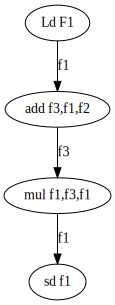

In [ ]:
from graphviz import Digraph
fsm = Digraph()
fsm.node('1','Ld F1')
fsm.node('2','add f3,f1,f2')
fsm.node('3','mul f1,f3,f1')
fsm.node('4','sd f1')
fsm.edge('1','2','f1')
fsm.edge('2','3','f3')
fsm.edge('3','4','f1')

fsm

## Exemplo 3

```
LOOP: ld F1,0(r1)
add F1,F1,F2
sd F1,0(r1)
ld F1,4(r1)
mul F1,F1,F2
sd F1,0(r1)
add r1,r1,8
bne r1,r2,LOOP
```

## Exemplo 4

```
LOOP: ld F1,0(r1)
add F1,F1,F2
mul F1,F1,F2
sd F1,0(r1)
ld F1,4(r1)
mul F1,F1,F2
sd F1,0(r1)
add r1,r1,8
bne r1,r2,LOOP
```

## Exemplo 5

```
LOOP: ld F1,0(r1)
add F3,F1,F2
mul F1,F1,F3
sd F1,0(r1)
ld F1,4(r1)
mul F1,F1,F3
sd F1,0(r1)
add r1,r1,8
bne r1,r2,LOOP
```

# Escalonamento Dinâmico

## **Questao 2 Prova 2023**

2 estacoes de reserva para: Ld, add, Mult

In [ ]:
%%writefile exemplo1.csv
instrucao; F; D; E; W; F; D; E; W;
loop LD F1,0(r1); 1; 2; 3-4; 5 L0;
Add F2,F1,F3; 2; 3; 4,5-7;8 A0;
SD F2,0(r1); 3; 4;5,8-9; L0;
LD F4,4(r1); 4; 5; 6-7,8; 9 L1;
Mul F5,F4,F4; 5; 6;7,9
Add F6,F5,F4; 6; 7;8,
Sd F6,4(r1); 7;
add r1,r1,8;
bne r1,r2, loop;


Overwriting exemplo1.csv


In [ ]:
%%writefile exemplo2.csv
instrucao; F; D; E; W; F; D; E; W;
loop LD F1,0(r1); 1; 2; 3-4; 5 L0;
Add F2,F1,F3; 2; 3; 4,5-7;8 A0;
SD F2,0(r1); 3; 4;5,8-9; L0;
LD F4,4(r1); 4; 5; 6-7,8; 9 L1;
Mul F5,F4,F4; 5; 6;7,9-13;14 M0;
Add F6,F5,F4; 6; 7;8,14-16;17 A0;
Sd F6,4(r1); 7; 8; 9,17-18; L1
add r1,r1,8; 8;
bne r1,r2, loop;


Overwriting exemplo2.csv


In [ ]:
%%writefile exemplo3.csv
instrucao; F; D; E; W; F; D; E; W;
loop LD F1,0(r1); 1; 2; 3-4; 5 L0; 10; 11; 12-13,14; 15 L0
Add F2,F1,F3; 2; 3; 4,5-7;8 A0;
SD F2,0(r1); 3; 4;5,8-9; L0;
LD F4,4(r1); 4; 5; 6-7,8; 9 L1;
Mul F5,F4,F4; 5; 6;7,9-13;14 M0;
Add F6,F5,F4; 6; 7;8,14-16;17 A0;
Sd F6,4(r1); 7; 8; 9,17-18; L1
add r1,r1,8; 8; 9;10;11;
bne r1,r2, loop; 9;


Overwriting exemplo3.csv


In [ ]:
%%writefile exemplo4.csv
instrucao; F; D; E; W; F; D; E; W;
loop LD F1,0(r1); 1; 2; 3-4; 5 L0; 10; 11; 12-13,14; 15 L0
Add F2,F1,F3; 2; 3; 4,5-7;8 A0; 11; 12; 13,15-17; 18 A1
SD F2,0(r1); 3; 4;5,8-9; L0; 12; 13-14; 15,18-19; L0;
LD F4,4(r1); 4; 5; 6-7,8; 9 L1; 13-14;
Mul F5,F4,F4; 5; 6;7,9-13;14 M0;
Add F6,F5,F4; 6; 7;8,14-16;17 A0;
Sd F6,4(r1); 7; 8; 17-18; L1
add r1,r1,8; 8; 9;10;11;
bne r1,r2, loop; 9;


Overwriting exemplo4.csv


In [ ]:
%%writefile exemplo5.csv
instrucao; F; D; E; W; F; D; E; W;
loop LD F1,0(r1); 1; 2; 3-4; 5 L0; 10; 11; 12-13,14; 15 L0
Add F2,F1,F3; 2; 3; 4,5-7;8 A0; 11; 12; 13,15-17; 18 A1
SD F2,0(r1); 3; 4;5,8-9; L0; 12; 13-14; 15,18-19; L0
LD F4,4(r1); 4; 5; 6-7,8; 9 L1; 13-14; 15-18; 19-20; 21 L1
Mul F5,F4,F4; 5; 6;7,9-13;14 M0; 15-18; 19; 20,21-25; 26 M0
Add F6,F5,F4; 6; 7;8,14-16;17 A0; 19;
Sd F6,4(r1); 7; 8; 17-18; L1
add r1,r1,8; 8; 9;10;11;
bne r1,r2, loop; 9;


Overwriting exemplo5.csv


In [ ]:
%%writefile exemplo6.csv
instrucao; F; D; E; W; F; D; E; W;
loop LD F1,0(r1); 1; 2; 3-4; 5 L0; 10; 11; 12-13,14; 15 L0
Add F2,F1,F3; 2; 3; 4,5-7;8 A0; 11; 12; 13,15-17; 18 A1
SD F2,0(r1); 3; 4;5,8-9; L0; 12; 13-14; 15,18-19; L0
LD F4,4(r1); 4; 5; 6-7,8; 9 L1; 13-14; 15-18; 19-20; 21 L1
Mul F5,F4,F4; 5; 6;7,9-13;14 M0; 15-18; 19; 20,21-25; 26 M0
Add F6,F5,F4; 6; 7;8,14-16;17 A0; 19; 20; 21,26-28; 29 A0
Sd F6,4(r1); 7; 8; 17-18; L1; 20; 21; 22,29-30; L0
add r1,r1,8; 8; 9;10;11; 21; 22; 23; 24
bne r1,r2, loop; 9; ; ; ; 22;



Overwriting exemplo6.csv


In [ ]:
#@title Imagens botões << e >>>
import pandas as pd
import ipywidgets as widgets
from IPython.display import Image
from IPython.display import clear_output
import time

first = 1
last = 6
filename = "exemplo"

from IPython.display import Markdown
marklist = []
marklist.append("conflito em W no ciclo 8, LD e ADD, atrasa LD para ciclo 9")
marklist.append("bloqueia no decode pois não tem unidade livre no ciclo 8")
marklist.append("Desvio especulativo comeca no ciclo 11 a iteracao 2")
marklist.append("ciclo 15, verificar se tem estacao de LOAD livre")
marklist.append("Esperar até ciclo 18 para liberar estacao de LOAD")
marklist.append("12 ciclos / 9 instrucoes = 1,33")

upbutton = widgets.Button(description='>>')
downbutton = widgets.Button(description='<<')



out = widgets.Output()
count = first
samp_text = filename + str(first) + ".csv"


def up_button_clicked(_, incr=1):
  global count,samp_text
  with out:
    if (count < last and  incr == 1):
      count += incr

    if (count > first and incr == -1):
      count += incr

    clear_output(wait=True)
    samp_text = filename + str(count) + ".csv"
    df = pd.read_csv(samp_text, delimiter=';',dtype="str")
    df = df.fillna("-")
    display(df)
    display(Markdown('## '+marklist[count-1]))

upbutton.on_click(up_button_clicked)

def down_button_clicked(_):
  return up_button_clicked(_, -1)

downbutton.on_click(down_button_clicked)
# displaying button and its output together
buttons = widgets.HBox([downbutton,upbutton])
#widgets.VBox([buttons,out,Image(samp_text)])

myvbox = widgets.VBox([buttons,out],)

display(myvbox)
with out:
  df = pd.read_csv(filename + str(first) + ".csv", delimiter=';',dtype="str")
  df = df.fillna("-")
  display(df)
  display(Markdown('## '+marklist[first-1]))



## Exemplo 1
```
Loop: LD F1,0(R1)
ADD F1,F1,F2
LD F2,8(R1)
MUL F3,F2,F1
MUL F4,F3,F5
Sub R1,r1,32
BNEZ R1,LOOP
```

Com encaminhamento (forward) Escalonamento dinâmico
- Suponha para ponto flutuante, 2 unidades de ADD em 4 ciclos, 2 unidade de MUL em 6 ciclos, 4 unidades de LD e SD em 2
ciclos, Inteiros em 1 ciclo e execução especulativa. Complete duas interações do LOOP abaixo

In [ ]:
#@title duas primeiras instrucoes
%%writefile exemplo1.csv
instruçao; F; I; X; W; F; I; X; W; Comentario
LD F1,0(R1); 1; 2; 3-4; 5 (L1)*;
ADD F1,F1,F2; 2; 3; 4,5-8; 9 (A1)+;
LD F2,8(R1);
MUL F3,F2,F1
MUL F4,F3,F5
Sub R1,r1,32
BNEZ R1,LOOP

Writing exemplo1.csv


In [ ]:
#@title ciclo 9
%%writefile exemplo2.csv
instruçao; F; I; X; W; F; I; X; W; Comentario
LD F1,0(R1); 1; 2; 3-4; 5 (L1)*; 8; 9;
ADD F1,F1,F2; 2; 3; 4,5-8; 9 (A1)+; 9;
LD F2,8(R1); 3; 4; 5-6; 7 (L2);
MUL F3,F2,F1; 4; 5; 6,9..; (M1);
MUL F4,F3,F5; 5; 6; 7,...; (M2);
Sub R1,r1,32; 6; 7; 8; 9;
BNEZ R1,LOOP; 7;

Writing exemplo2.csv


In [ ]:
#@title ciclo 26
%%writefile exemplo3.csv
instruçao; F; I; X; W; F; I; X; W; F; I; X; W;
LD F1,0(R1); 1; 2; 3-4; 5 (L1); 8; 9; 10-11; 12 (L1) ; 22; 23;24-25;26(L1)
ADD F1,F1,F2; 2; 3; 4,5-8; 9 (A1); 9; 10;11,12-15; 16 (A1)
LD F2,8(R1); 3; 4; 5-6; 7 (L1); 10; 11; 12-13; 14 (L1)
MUL F3,F2,F1; 4; 5; 6,9-14; 15 (M1); 12; 13-14**; 15,16-21;22(M1)
MUL F4,F3,F5; 5; 6; 7,15-20; 21 (M2); 13-14; 15-20; 21,22-27;28 (M2)
Sub R1,r1,32; 6; 7; 8; 9; 15-20; 21; 22; 23;
BNEZ R1,LOOP; 7;  ;  ;  ; 21;

Overwriting exemplo3.csv


In [ ]:
#@title Imagens botões << e >>>
import pandas as pd
import ipywidgets as widgets
from IPython.display import Image
from IPython.display import clear_output
import time

first = 1
last = 3
filename = "exemplo"

from IPython.display import Markdown
marklist = []
marklist.append("Add é emitido no ciclo 4 e começa a executar no 5 \n * LD na estacao L1 \n + ADD na estacao A1")
marklist.append("Começou a execução 2 iteracao \n * Estacao M1 Valor L2 Aguarda A1 \n * Estacao M2 valor F5 Aguarda M1")
marklist.append("Faltou estacao Mult, travou no Issue, CPI= 2")

upbutton = widgets.Button(description='>>')
downbutton = widgets.Button(description='<<')



out = widgets.Output()
count = first
samp_text = filename + str(first) + ".csv"


def up_button_clicked(_, incr=1):
  global count,samp_text
  with out:
    if (count < last and  incr == 1):
      count += incr

    if (count > first and incr == -1):
      count += incr

    clear_output(wait=True)
    samp_text = filename + str(count) + ".csv"
    df = pd.read_csv(samp_text, delimiter=';',dtype="str")
    df = df.fillna("-")
    display(df)
    display(Markdown('## '+marklist[count-1]))

upbutton.on_click(up_button_clicked)

def down_button_clicked(_):
  return up_button_clicked(_, -1)

downbutton.on_click(down_button_clicked)
# displaying button and its output together
buttons = widgets.HBox([downbutton,upbutton])
#widgets.VBox([buttons,out,Image(samp_text)])

myvbox = widgets.VBox([buttons,out],)

display(myvbox)
with out:
  df = pd.read_csv(filename + str(first) + ".csv", delimiter=';',dtype="str")
  df = df.fillna("-")
  display(df)
  display(Markdown('## '+marklist[first-1]))



# Superscalar

## Exemplo Escalonamento Dinamico e Superscalar 2 em 2

* add 2 unidades, 3 ciclos
* mul 2 unidades, 5 ciclos
* ld 3 unidades, 2 ciclos

In [ ]:
%%writefile exemplo1.csv
inst; F; I; X; W; F; I; X; W;
Loop: LD F1,0(R1); 1; 2
LD F2,8(R1); 1; 2;
Sub R1,r1,32; 2;
MUL F3,F2,F2 ;2;
ADD F1,F1,F2
SD F1,16(R1)
MUL F4,F3,F4
BNEZ R1, LOOP

Overwriting exemplo1.csv


In [ ]:
%%writefile exemplo2.csv
inst; F; I; X; W; F; I; X; W;
Loop: LD F1,0(R1); 1; 2; 3-4;5 (L1); 5; 6; 7-8,9; 10 (L2)
LD F2,8(R1); 1; 2; 3-45;6 (L2); 5; 6; 7-9,11; 12 (L3)
Sub R1,r1,32; 2; 3;4;5 (int); 6;
MUL F3,F2,F2 ;2;3;4-6-10;11 (M1); 6;
ADD F1,F1,F2;3;4; 56-8; 9 (A1)
SD F1,16(R1);3;4;5,9-10; - (L1)
MUL F4,F3,F4; 4; 5;6,11-15; 16 (M2);
BNEZ R1, LOOP; 4; ;      ; ;

Overwriting exemplo2.csv


In [ ]:
%%writefile exemplo3.csv
inst; F; I; X; W; F; I; X; W; F1
Loop: LD F1,0(R1); 1; 2; 3-4;5 (L1); 5; 6; 7-8,9; 10 (L2); 12-15; 16; 17-18;19
LD F2,8(R1); 1; 2; 3-45;6 (L2); 5; 6; 7-9,11; 12 (L3); 12-15
Sub R1,r1,32; 2; 3;4;5 (int); 6; 7; 8; 9
MUL F3,F2,F2 ;2;3;4-6-10;11 (M1); 6;7-10; 11,12-16; 17(M1)
ADD F1,F1,F2;3;4; 56-8; 9 (A1); 7-10; 11; 12-14;15(A1)
SD F1,16(R1);3;4;5,9-10; - (L1); 7-10; 11; 15-16; (L1)
MUL F4,F3,F4; 4; 5;6,11-15; 16 (M2); 11; 12-15; 16,17..;(M2)
BNEZ R1, LOOP; 4; ;      ; ; 11; 12;

Overwriting exemplo3.csv


In [ ]:
#@title Imagens botões << e >>>
import pandas as pd
import ipywidgets as widgets
from IPython.display import Image
from IPython.display import clear_output
import time

first = 1
last = 3
filename = "exemplo"

from IPython.display import Markdown
marklist = []
marklist.append("Dispara duas intrucoes por vez")
marklist.append("Atenção as gravacoes (W) e numero de estacoes de reserva")
marklist.append("CPI da 3 e 2 iteracao, olhando load \n CPI = (19-10)/8=1.125 > 0.5")

upbutton = widgets.Button(description='>>')
downbutton = widgets.Button(description='<<')



out = widgets.Output()
count = first
samp_text = filename + str(first) + ".csv"


def up_button_clicked(_, incr=1):
  global count,samp_text
  with out:
    if (count < last and  incr == 1):
      count += incr

    if (count > first and incr == -1):
      count += incr

    clear_output(wait=True)
    samp_text = filename + str(count) + ".csv"
    df = pd.read_csv(samp_text, delimiter=';',dtype="str")
    df = df.fillna("-")
    display(df)
    display(Markdown('## '+marklist[count-1]))

upbutton.on_click(up_button_clicked)

def down_button_clicked(_):
  return up_button_clicked(_, -1)

downbutton.on_click(down_button_clicked)
# displaying button and its output together
buttons = widgets.HBox([downbutton,upbutton])
#widgets.VBox([buttons,out,Image(samp_text)])

myvbox = widgets.VBox([buttons,out],)

display(myvbox)
with out:
  df = pd.read_csv(filename + str(first) + ".csv", delimiter=';',dtype="str")
  df = df.fillna("-")
  display(df)
  display(Markdown('## '+marklist[first-1]))



# VLIW

# Predição de Desvios

# outros recursos

In [ ]:
#@title Imprime e Edita
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML
from IPython.display import Markdown
display(Markdown('## Irar parar no decode nos ciclos 3-4 devido a dependência em f1'))
display(Markdown('## Efeito em cascata que segura a instrução mult no Fetch'))

# Lê o arquivo CSV e carrega em um dataframe
df = pd.read_csv('exemplo.csv', delimiter=';',dtype=str)
df = df.fillna("-")

# create a dictionary to store input widgets for each cell
input_widgets = {}

# create a function to update the DataFrame based on the input widget values
def update_df(sender):
    for index, row in df.iterrows():
        for col in df.columns:
            widget = input_widgets[(index, col)]
            if isinstance(widget, widgets.Dropdown):
                df.loc[index, col] = widget.value
            elif isinstance(widget, widgets.Text):
                try:
                    value = int(widget.value)
                except ValueError:
                    value = widget.value
                df.loc[index, col] = value

# display the DataFrame as a table with input widgets for each cell
display(HTML(df.to_html(index=False)))
for index, row in df.iterrows():
    for col in df.columns:
        value = row[col]
        if isinstance(value, int):
            widget = widgets.IntText(value=value)
        elif isinstance(value, str):
            widget = widgets.Text(value=value)
        else:
            # create dropdown widget for categorical columns
            options = sorted(df[col].unique().tolist())
            widget = widgets.Dropdown(options=options, value=value)
        # store the widget in the input_widgets dictionary
        input_widgets[(index, col)] = widget
        widget.observe(update_df)
        display(widget, end=' ')
    print()

# add a button to submit changes
submit_button = widgets.Button(description='Submit changes')
submit_button.on_click(update_df)
display(submit_button)


## Irar parar no decode nos ciclos 3-4 devido a dependência em f1

## Efeito em cascata que segura a instrução mult no Fetch

PC,instrução,F,D,X,W,Unnamed: 6
0,"ld f1,0(r5)",1,2,3-4,5,-
4,"add f1,f1,f3",2,3-4,5,-,-
8,"mult f2,f1,f1",3-4,-,-,-,-
12,"add f4,f1,f2",-,-,-,-,-
16,"sd f1,0(r5)",-,-,-,-,-
20,"add r5,r5,4",-,-,-,-,-
24,"beq r5,r2,loop",-,-,-,-,-


Text(value='0')

Text(value=' ld f1,0(r5) ')

Text(value=' 1')

Text(value=' 2')

Text(value=' 3-4')

Text(value=' 5')

Text(value='-')

Text(value='4')

Text(value='  add f1,f1,f3')

Text(value=' 2')

Text(value=' 3-4')

Text(value=' 5')

Text(value='-')

Text(value='-')

Text(value='8')

Text(value=' mult f2,f1,f1')

Text(value=' 3-4')

Text(value='-')

Text(value='-')

Text(value='-')

Text(value='-')

Text(value='12')

Text(value=' add f4,f1,f2')

Text(value='-')

Text(value='-')

Text(value='-')

Text(value='-')

Text(value='-')

Text(value='16')

Text(value=' sd f1,0(r5)')

Text(value='-')

Text(value='-')

Text(value='-')

Text(value='-')

Text(value='-')

Text(value='20')

Text(value='  add r5,r5,4')

Text(value='-')

Text(value='-')

Text(value='-')

Text(value='-')

Text(value='-')

Text(value='24')

Text(value=' beq r5,r2,loop')

Text(value='-')

Text(value='-')

Text(value='-')

Text(value='-')

Text(value='-')

Button(description='Submit changes', style=ButtonStyle())